In [15]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 
#%matplotlib notebook
%config InlineBackend.figure_format = 'retina'


In [55]:
date="20190417"
expnum=487
exposure=(str(expnum).zfill(6))
filename="/project/bstalder/comcam/raw/"+date+"/CC_C_"+date+"_"+exposure+"/CC_C_"+date+"_"+exposure+"_R22_S11.fits"
bias=fits.open(filename)
#print(repr(bas[0].header))

expnum=488
exposure=(str(expnum).zfill(6))
filename="/project/bstalder/comcam/raw/"+date+"/CC_C_"+date+"_"+exposure+"/CC_C_"+date+"_"+exposure+"_R22_S11.fits"
flat1=fits.open(filename)

expnum=489
exposure=(str(expnum).zfill(6))
filename="/project/bstalder/comcam/raw/"+date+"/CC_C_"+date+"_"+exposure+"/CC_C_"+date+"_"+exposure+"_R22_S11.fits"
flat2=fits.open(filename)


698.3125196850393 2641.872850143331


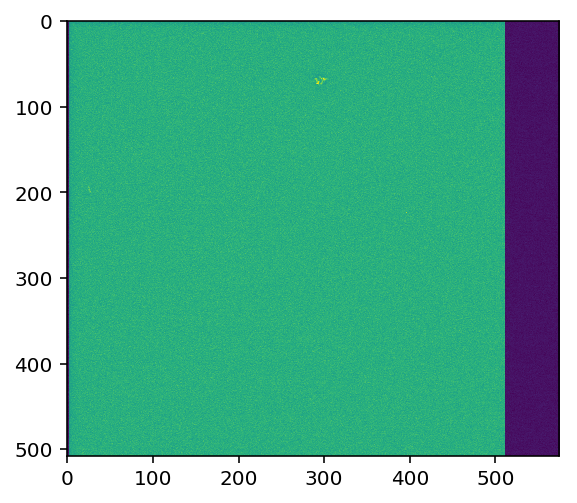

In [56]:
#print(repr(bias[9].header))
xmin=4
xmax=512
ymin=1
ymax=2000

biasamp=bias[9].data[xmin:xmax,ymin:ymax]
flat1amp=flat1[9].data[xmin:xmax,ymin:ymax]
flat2amp=flat2[9].data[xmin:xmax,ymin:ymax]

plt.imshow(flat1amp-biasamp)
signal=np.mean( flat1amp-biasamp)
variance=np.std( (flat1amp-flat2amp)**2 )

print(signal, variance)

bias.close()
flat1.close()
flat2.close()

In [57]:
date="20190417"
xmin=150
xmax=350
ymin=150
ymax=350
amp=6

signal = []
variance = []


for i in range(487,593,3):
#    print(i)
    biasnum=str(i).zfill(6)
    flat1num=str(i+1).zfill(6)
    flat2num=str(i+2).zfill(6)
    biasfile="/project/bstalder/comcam/raw/"+date+"/CC_C_"+date+"_"+biasnum+"/CC_C_"+date+"_"+biasnum+"_R22_S11.fits"
    flat1file="/project/bstalder/comcam/raw/"+date+"/CC_C_"+date+"_"+flat1num+"/CC_C_"+date+"_"+flat1num+"_R22_S11.fits"
    flat2file="/project/bstalder/comcam/raw/"+date+"/CC_C_"+date+"_"+flat2num+"/CC_C_"+date+"_"+flat2num+"_R22_S11.fits"
    with fits.open(biasfile) as bias:
        biasamp=bias[amp].data[xmin:xmax,ymin:ymax]
    with fits.open(flat1file) as flat1:
        flat1amp=flat1[amp].data[xmin:xmax,ymin:ymax]
#        print(flat1[0].header['EXPTIME'])
    with fits.open(flat2file) as flat2:
        flat2amp=flat2[amp].data[xmin:xmax,ymin:ymax]
    
    signal.append(np.mean( flat1amp-biasamp))
    variance.append(np.std( (flat1amp-flat2amp)**2 ))



[0, 180000, 0, 1250000]

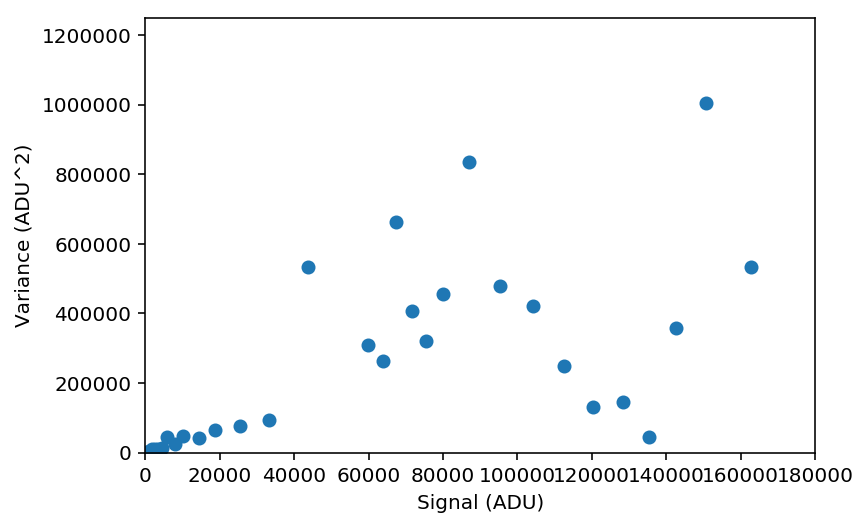

In [58]:
plt.figure()
plt.scatter(signal, variance)
plt.xlabel('Signal (ADU)')
plt.ylabel('Variance (ADU^2)')
plt.axis([0,180000,0,1250000])